In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
!curl -fsS http://udon.stacken.kth.se/\~ninjin/comp0090_assignment_1_data.tar.gz -o /tmp/data.tar.gz
!tar -x -z -f /tmp/data.tar.gz
!rm -f /tmp/data.tar.gz

In [3]:
trainxs = np.load("comp0090_assignment_1_data/fashion-train-imgs.npz").transpose((2, 1, 0))
trainys = np.load("comp0090_assignment_1_data/fashion-train-labels.npz")
devxs   = np.load("comp0090_assignment_1_data/fashion-dev-imgs.npz").transpose((2, 1, 0))
devys   = np.load("comp0090_assignment_1_data/fashion-dev-labels.npz")
testxs  = np.load("comp0090_assignment_1_data/fashion-test-imgs.npz").transpose((2, 1, 0))
testys  = np.load("comp0090_assignment_1_data/fashion-test-labels.npz")

In [4]:
print(trainxs.shape)
print(trainys.shape)
print(devxs.shape)
print(devys.shape)
print(testxs.shape)
print(testys.shape)

(12000, 28, 28)
(12000,)
(1000, 28, 28)
(1000,)
(1000, 28, 28)
(1000,)


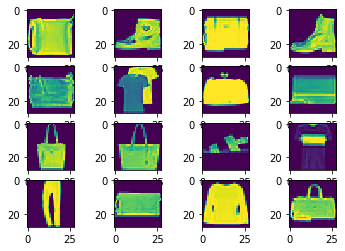

In [5]:
f, axarr = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        axarr[i, j].imshow(trainxs[np.random.randint(0, len(trainxs))])

## 1.1 Deriving memory efficient algorithm
To obtain a version of the algorithm with memory efficiency O(1), it is necessary to store the sum of all weights obtained during the training, and use it to make a prediction. In pseudocode, that would look as follows:<br> 
$\textbf{Data:} \mathcal{D} := \{(\mathbf{x_1},y_1),...,(\mathbf{x_n}, y_n)\}\\                     
\textbf{Result:} \mathcal{v} := \{\mathbf{w}\}\\            
\mathbf{w} := 0^d\\                          
\mathbf{s} := 0^d\\
\textbf{while} \quad \textit{not converged} \quad \textbf{do}\\                          
\qquad \textbf{for} \quad i := 1,...,n \quad \textbf{do}\\              
\qquad \qquad \hat{y} =
  \begin{cases}
    1  & \quad \mathbf{w} \cdot \mathbf{x_i} \geq 0\\
    0  & \quad \text{otherwise}
  \end{cases}\\               
\qquad \qquad \textbf{if} \quad \hat{y} \neq y \quad \textbf{then}\\                 
\qquad \qquad \quad \mathbf{w} = \mathbf{w} + (y - \hat{y})\mathbf{x_i}\\          
\qquad \qquad \textbf{end}\\  
\qquad \qquad \mathbf{s} = \mathbf{s} + \mathbf{w}\\
\qquad \textbf{end}\\
\textbf{end}$  

Prediction then is done as follows:<br>
$$f(\mathbf{x}) = 
    \begin{cases}
        1 \quad \mathbf{s} \cdot \mathbf{x} \geq 0\\
        0 \quad \text{otherwise}
    \end{cases}$$

## 1.2 Proving functional equivalence
Consider initial prediction formula,<br> $ \begin{equation}
  f(\mathbf{x})=\begin{cases}
    1, & \text{if $\sum_{i:=1}^{k}c_i(\mathbf{w_i}\cdot \mathbf{x})\geq 0$}\\
    0, & \text{otherwise}
  \end{cases}
\end{equation} $<br>
We can rewrite the expression as follows:<br>
$$
    \displaystyle\sum^{k}_{i=1} c_i(\mathbf{w_i} \cdot \mathbf{x}) =
    \displaystyle\sum^{k}_{i=1} c_i \displaystyle\sum^{d}_{j=1} (\mathbf{w_i})_j x_j\\
    = \displaystyle\sum^{k}_{i=1} \displaystyle\sum^{d}_{j=1} c_i (\mathbf{w_i})_j x_j = 
    \displaystyle\sum^{d}_{j=1} \displaystyle\sum^{k}_{i=1} c_i (\mathbf{w_i})_j x_j\\
    = \displaystyle\sum^{d}_{j=1} x_j \bigg(\displaystyle\sum^{k}_{i=1} c_i (\mathbf{w_i})_j \bigg) = 
    \displaystyle\sum^{d}_{j=1} x_j \bigg(\displaystyle\sum^{k}_{i=1} c_i \mathbf{w_i} \bigg)_j\\
    = \mathbf{x} \cdot \mathbf{s} \\
$$<br>
The sum of scaled weights is equivalent to adding weights on each iteration and storing the resulting sum, which then can be used to make predictions.<br>

## 1.3 Efficient Version Implementation

In [6]:
# reshape data to make it easier to work with
trainxs = trainxs.reshape(-1, 784)
devxs = devxs.reshape(-1, 784)
testxs = testxs.reshape(-1, 784)

In [7]:
# function to create weight and sum parameters for the algorithm
def initialise_parameters(xs):
    w = np.zeros(xs.shape[1])
    s = np.zeros(xs.shape[1])
    return w, s

In [8]:
def efficient_voted_perceptron(xs, ys, devxs, devys):
    w, s = initialise_parameters(xs)
    
    # store old accuracy and consecutive epochs count to detect convergence
    acc_old = accuracy(xs, ys, s)
    row_epoch = 0
    
    # store training and validation set accuracy for parts 1.5-1.6
    accuracy_training = []
    accuracy_validation = []
    
    # store number of epochs to have a nice graph
    epoch = 0
        
    while True:
        print('Epoch', epoch)
        
        for i in range (xs.shape[0]):
            y_hat = predict_voted(w, xs[i])
            if y_hat != ys[i]:
                 w = w + (ys[i] - y_hat) * xs[i]
            s += w
            
        # store resulting accuracies
        accuracy_train = accuracy(xs, ys, s)
        accuracy_training.append(accuracy_train)
        print('Training set accuracy:', accuracy_train)
        
        accuracy_dev = accuracy(devxs, devys, s)
        accuracy_validation.append(accuracy_dev)
        print('Validation set accuracy:', accuracy_dev)

        # check if converged
        if np.abs(accuracy_train - acc_old) < 0.1:
            row_epoch += 1
            if row_epoch == 5:
                break
        else:
            row_epoch = 0
            
        acc_old = accuracy_train
        epoch += 1
    
    return s, epoch, accuracy_training, accuracy_validation

In [9]:
# function to calculate prediction accuracy
def accuracy(devxs, devys, s):
    accuracy = 0.0
    for i in range (devxs.shape[0]):
        if (predict_voted(s, devxs[i]) == devys[i]):
            accuracy += 1
    return (accuracy / devys.shape[0]) * 100

In [10]:
# function to make predictions with voted perceptron
def predict_voted(s, x):
    if np.dot(s, x) >= 0:
        return 1
    return 0

## 1.4 Train model to convergence

Convergence is defined as having the difference between training set accuracies obtained from two consecutive epochs being less than 0.1 five times in a row.

In [11]:
s, epoch, accuracy_training, accuracy_validation = efficient_voted_perceptron(trainxs, trainys, devxs, devys)

Epoch 0
Training set accuracy: 96.58333333333333
Validation set accuracy: 96.89999999999999
Epoch 1
Training set accuracy: 96.84166666666667
Validation set accuracy: 97.6
Epoch 2
Training set accuracy: 97.0
Validation set accuracy: 97.8
Epoch 3
Training set accuracy: 97.14166666666667
Validation set accuracy: 97.7
Epoch 4
Training set accuracy: 97.13333333333334
Validation set accuracy: 97.7
Epoch 5
Training set accuracy: 97.25
Validation set accuracy: 97.7
Epoch 6
Training set accuracy: 97.25
Validation set accuracy: 97.7
Epoch 7
Training set accuracy: 97.30833333333334
Validation set accuracy: 97.7
Epoch 8
Training set accuracy: 97.29166666666667
Validation set accuracy: 97.6
Epoch 9
Training set accuracy: 97.31666666666666
Validation set accuracy: 97.7
Epoch 10
Training set accuracy: 97.35000000000001
Validation set accuracy: 97.6


## 1.5 Accuracy plot for training set

For this task, we have to adjust our algorithm to store accuracy for each epoch.

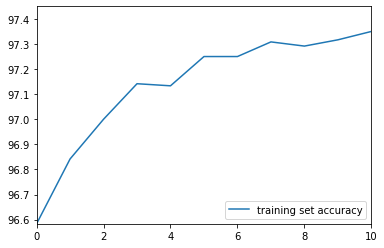

In [12]:
plt.axis([0, epoch, min(accuracy_training), max(accuracy_training) + 0.1])
plt.plot(accuracy_training, label='training set accuracy')
plt.legend(loc='lower right')

## 1.6 Accuracy for best epoch

In [13]:
ind = accuracy_validation.index(max(accuracy_validation))

In [14]:
print("Best epoch =", ind)
print("Accuracy on training set =", accuracy_training[ind])
print("Accuracy on validation set =", accuracy_validation[ind])

Best epoch = 2
Accuracy on training set = 97.0
Accuracy on validation set = 97.8
